In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import pandas as pd

In [2]:
import seaborn as sb

In [31]:
from scipy.stats import norm

# Modelo estocástico y reducción de ruido.

## Introducción

Las matrices de correlación entre compañías usualmente se encuentran cubiertas de ruido, dicho recubrimiento es mayor mientras más cortas sean las series de tiempo. El articúlo de Thomas Guhr and Bernd Kälber del 2003 "A new method to estimate the noise in financial correlation matrices" propone  un método llamado "mapeo de potencias" para discernir entre el ruido y las correlaciones verdaderas en la distribución de eigenvalores de estas matrices. El mapeo de potencias se basa en la ecuación:

$$
C(k, l)_T \rightarrow sign(C(k,l)_T)|C(k,l)_T|^q
$$
A lo largo del artículo se observa que este mapeo tiene un efecto de "Prolongar" las series de tiempo, reduciendo el ruido.
https://drive.google.com/file/d/1i_ayLRFLXsyUsN-s3Rn7FcV8F9Z6ytve/view?fbclid=IwZXh0bgNhZW0CMTEAAR281w5yslGU6INckMd4oAQKiQXZk5pPQvYG4pMrJBhV60kQqkyA3ofHGxk_aem_W2f35cp_HwWwaZk5xrVXdg


## Modelo estocástico

Consideremos un mercado de $K$ compañías que pueden pertenecer a $B$ ramas industriales. El conjunto de índices de la compañías será $\{k\} = \{1, 2,.., K\}$ y el de las ramas $\{b\} = \{1, 2,.., B\}$. De este modo, se tiene que:
$$
\sum_{b = 1}^B (\kappa_b) + \kappa = K 
$$
Donde $\kappa_b$ es el número de compañías que pertenecen a la rama $b$ y $\kappa$ es el número de compañías que no pertenece a ninguna  de las $B$ ramas


Si consideramos $b = b(k)$, la serie de rendimientos para la $k$-ésima compañía se modela como sigue:

\begin{equation}
M_k(t) = \sqrt{\frac{p_{b(k)}}{1 + p_{b(k)}}}\eta_{b(k)}(t) + \frac{1}{\sqrt{1 + p_{b(k)}}}\epsilon_k(t)
\end{equation}

Vemos que se compone de dos contribuciones aletorías, la v.a. $\eta_{b(k)}(t)$ es común a todas las compañías en la rama $b$, mientras que $\epsilon_k(t)$ es específica para cada  compañía. Ambas contribuciones están pesadas por un parámetro positivo no aleatorio $p_{b(k)}$ que también es común a todas las compañías de la rama $b$.
Para las compañías que no están en ninguna rama, tomamos $b=0$ y $p_{b(k)}=0$.
Supondremos que tanto $\eta$ como $\epsilon$ distribuyen normal estándar. 

In [3]:
#Realizacion del proceso M_k para compañías en una misma rama
def Mb(kappa_b , p_b, T):
    M = np.zeros([kappa_b, T])
    eta_b = np.random.normal(0,1)#el número aleatorio eta es el mismo para todas las compañías de la rama
    for k in range(kappa_b):
        for t in range(T):
            epsilon_k = np.random.normal(0,1) #Tomé M_k(t) como lo describe el artículo
            M[k][t] = (np.sqrt(p_b/(1+p_b)))*eta_b + np.sqrt(1/(1+p_b))*epsilon_k #epsilon depende de cada k compañía
    return M


In [4]:
M_b = Mb(10, 1-1/10, 200)

In [5]:
s1 = pd.Series(M_b[0])
s2 = pd.Series(M_b[8])

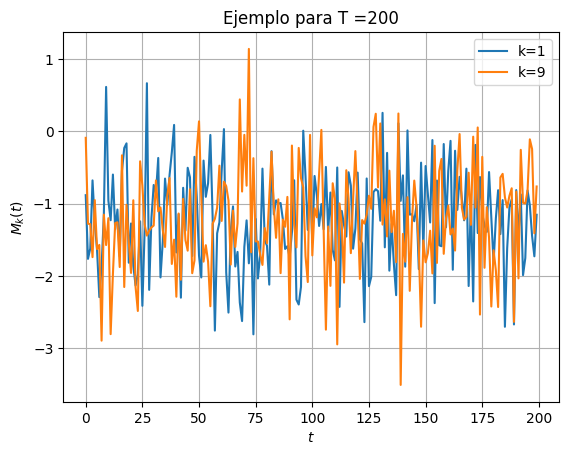

In [6]:
plt.title("Ejemplo para T =200")
plt.plot(s1, label = "k=1")
plt.plot(s2, label = "k=9")
plt.xlabel("$t$")
plt.ylabel("$M_k(t)$")
plt.grid()
plt.legend()

Tomamos B = 6, K = 508, $\kappa = 256$, con la repartición de compañías dada como sigue

In [7]:
#Escogemos los parámetros que se mencionan en la tabla 1 del artículo
K = 508
b = np.array([0,1,2,3,4,5,6])
kappas = np.zeros(7)
kappas[0] = 256
#ps = np.zeros(7)
#ps[0] = 0
ps = np.array([0, 0.75, 0.88, 0.94, 0.97, 0.98, 0.99])
for i in range(1,len(b), 1):
    kappas[i] = 2**(i+1)
#for i in range(1, len(b), 1):
    #ps[i] = 1 - 1/kappas[i] # p_b(k) = 1 - 1/\kappa_b

In [8]:
D = np.array([b, kappas, ps])
Tabla = pd.DataFrame(D, index=['b', 'kappa', 'p_b'])
Tabla.head()

,0,1,2,3,4,5,6
b,0.0,1.00,2.00,3.00,4.00,5.00,6.00
kappa,256.0,4.00,8.00,16.00,32.00,64.00,128.00
p_b,0.0,0.75,0.88,0.94,0.97,0.98,0.99


In [9]:
#Esta función hace las B + 1 realizaciones de M_k (una para cada rama industrial) y devuelve la matriz de correlación
def M(b, kappas, ps, T):
    M = []
    for i in range(len(b)):
        M.append(Mb(int(kappas[i]), ps[i], T))
    M = np.vstack(M)
    C = (1/T)*np.dot(M, np.transpose(M)) #tomo la matriz de correlación que describe el artículo
    return C

El coeficiente de correlación entre dos series de tiempo está dado por:
$$C(k, l)_T = \frac{1}{T}\sum_{t=1}^TM_k(t)M_l(t) = <M_k(t)M_l(t)>_T$$
Así, la matriz de correlaciones es:
\begin{equation}
C_T = \frac{1}{T}MM^{\tau}
\end{equation}
Recordemos que cuando $T \rightarrow \infty$ 

$$
<\eta_{b(k)}(t)>_{\infty} = <\epsilon_k(t)>_{\infty} = 0
$$
$$
<\eta_{b(k)}(t)\eta_{b(l)}(t)>_{\infty}  = \delta_{b(k)(l)}
$$
$$
<\epsilon_k(t)\epsilon_l(t)>_{\infty}  = \delta_{kl}
$$
$$
<\epsilon_k(t)\eta_{b(l)}(t)>_{\infty}  = 0
$$
Luego
\begin{equation}
C(k,l)_{\infty} = \frac{1}{1+p_{b(k)}}(p_{b(k)}\delta_{b(k)b(l)} + \delta_{kl})
\end{equation}

In [10]:
def  EMeigvals(b, kappas, ps, K,T, N=50):#Tiene los mismos argumentos que M, devuelve los eigenvalores de un ensamble de N matrices
  vec = np.zeros(N*K)
  cont = 0
  for i in range(N):
    matriz = M(b, kappas, ps,T)
    eigenvalores = np.linalg.eigvals(matriz)
    for j in range(K):
      vec[cont] = eigenvalores[j]
      cont += 1
  return vec

In [11]:
Ts = [1650, 5000, 20000, 50000] #Tomo las longitudes de tiempo que menciona el artículo

In [12]:
Matrices = []
for T in Ts:
    Matrices.append(M(b, kappas, ps,T))

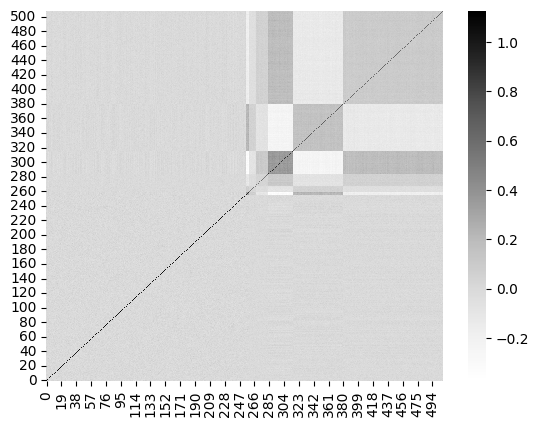

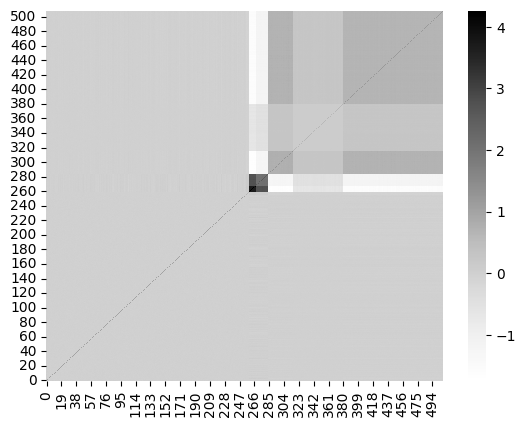

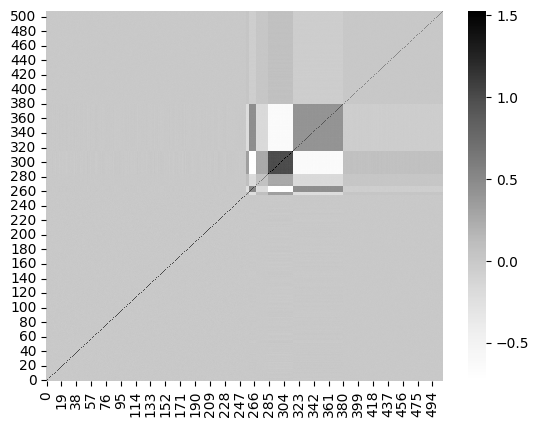

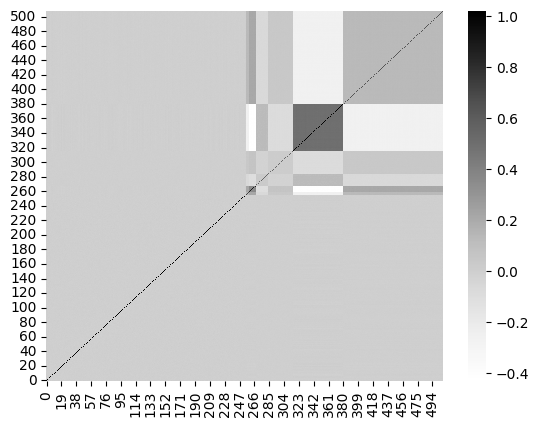

In [13]:
for c in Matrices:
    sb.heatmap(c, cmap= "Greys")
    plt.gca().invert_yaxis()
    plt.show()

En la práctica $T<\infty$, por lo que $<M_k(t)>$ no es exactamente 0 ni $<M_k(t)^2>$ es exactamente 1, luego haciendo uso del resultado:

$$
<\alpha_k(t)\alpha_l(t)> = \delta_{kl} + \sqrt{\frac{1+\delta_{kl}}{T}}a_{kl}
$$
Donde a y las $\alpha$'s distribuyen normal estándar y son independientes siempre que $k \neq l$, uno puede obtener:

$$

C(k, l)_T = \sqrt{\frac{p_{b(k)}}{1 + p_{b(k)}}}\sqrt{\frac{p_{b(l)}}{1 + p_{b(l)}}}(\delta_{b(k)b(l)} + \sqrt{\frac{1+\delta_{b(k)b(l)}}{T}}a_{b(k)b(l)}) + \sqrt{\frac{1}{1 + p_{b(k)}}}\sqrt{\frac{1}{1 + p_{b(l)}}}(\delta_{kl} +
\sqrt{\frac{1+\delta_{kl}}{T}}a_{kl}) $$
$$ + \sqrt{\frac{p_{b(k)}}{1+p_b(k)}}\sqrt{\frac{1}{1+p_{b(l)}}}\frac{1}{\sqrt{T}}a_{b(k)l} + \sqrt{\frac{p_{b(l)}}{1+p_b(l)}}\sqrt{\frac{1}{1+p_{b(k)}}}\frac{1}{\sqrt{T}}a_{b(l)k} + o(|\frac{1}{\sqrt{T}}|)
$$

Como es de esperarse, 

$$

\lim_{T \to \infty} C(k,l)_T = C(k,l)_{\infty}

$$

In [14]:
evals = []
for T in Ts:
    evals.append(EMeigvals(b, kappas, ps, K, T, N=25))


Para $T \rightarrow \infty$, La matriz de correlaciones tiene bloques diagonales de tamaño $\kappa_b \times \kappa_b$ y 1's en la diagonal, luego en cada bloque hay $\kappa_b - 1$ eigenvalores iguales a $\frac{1}{1+p_b}$ y uno igual a $\frac{1 + \kappa_b p_b}{1+p_b}$, además hay $\kappa$ eigenvalores iguales a 1 (por las compañías que no están en ninguna rama), luego la densidad espectral:

$$
\rho_{\infty}(\lambda) = \sum_{b = 1}^B(\kappa_b-1)\lambda\delta(\lambda - \frac{1}{1+p_b}) + \sum_{b = 1}^B\lambda\delta(\lambda - \frac{1 + \kappa_bp_b}{1+p_b}) + \kappa\delta(\lambda-1) 
$$

Para $T<\infty$:
$$
\rho_T(\lambda) \approx (K-\kappa-B)N(\frac{1}{2}, \frac{1}{T}) + \kappa\rho_{ch}(\lambda, \frac{\kappa}{T}) + \sum_{b = 1}^B\lambda\delta(\lambda - \frac{1 + \kappa_bp_b}{1+p_b}))
$$

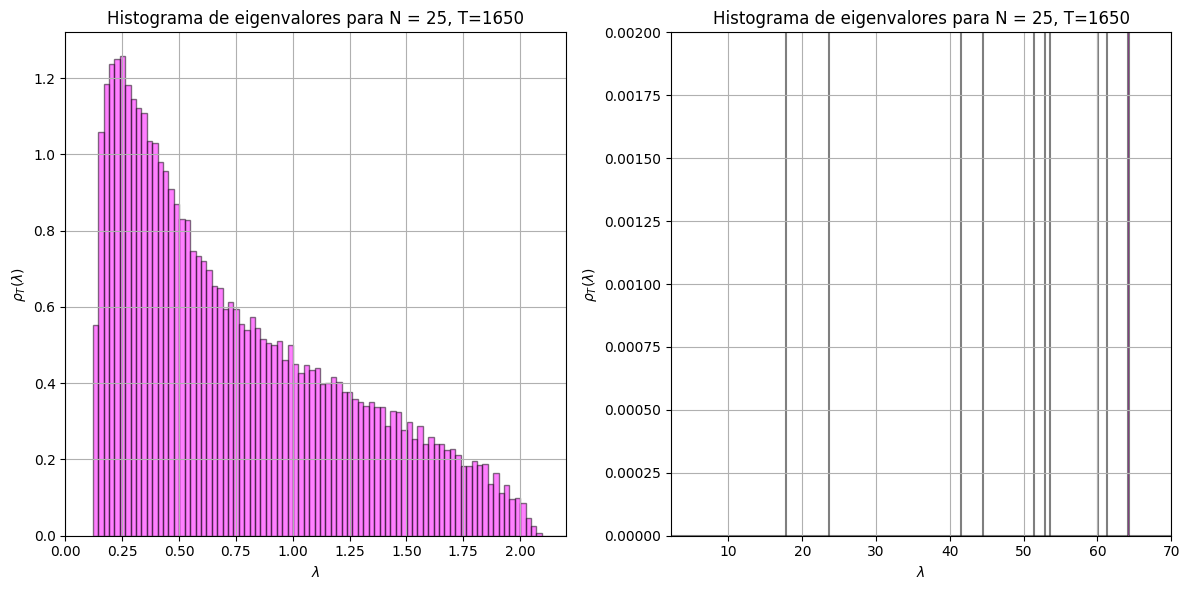

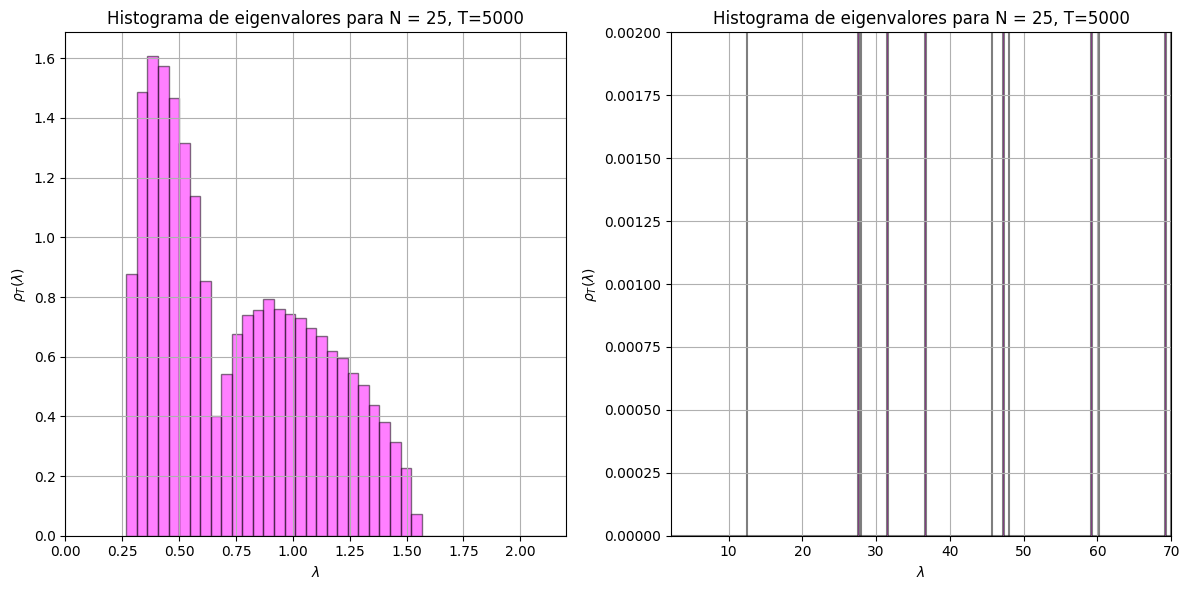

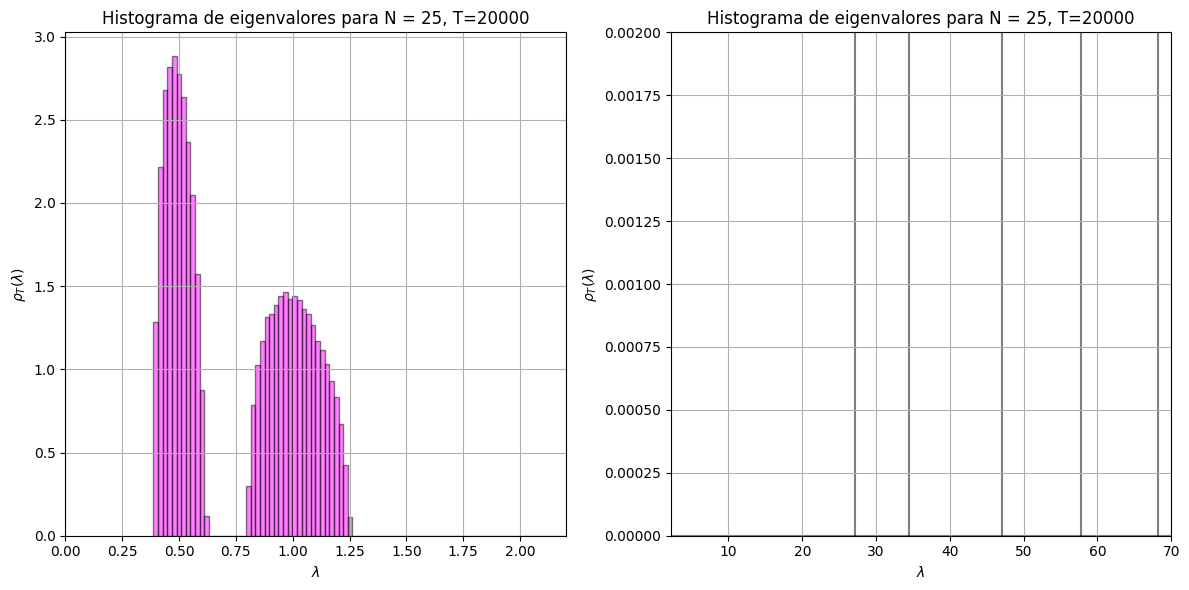

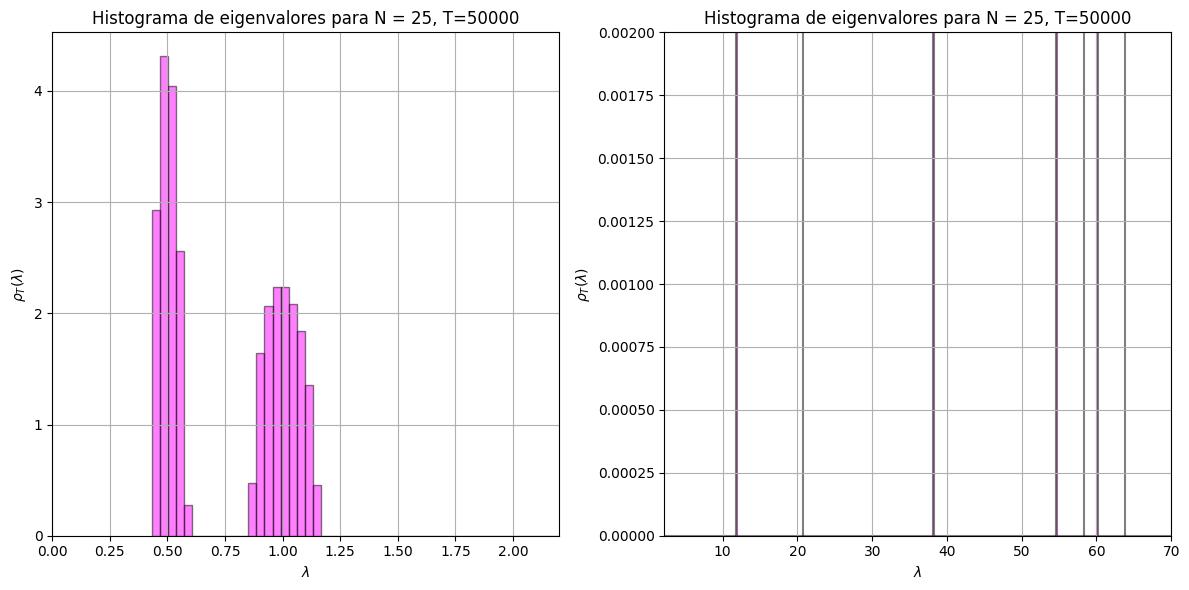

In [59]:
scale = (K-kappas[0]-6)
x = np.linspace(0,2.2,200)
for i in range(len(Ts)):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"Histograma de eigenvalores para N = 25, T={Ts[i]}")
    n, bins, patches = plt.hist(evals[i], bins = 15000, density= True, alpha = 0.5, color = "magenta", edgecolor = "black")
    plt.grid()
    plt.xlim(0, 2.2)
    plt.xlabel("$\\lambda$")
    plt.ylabel("$\\rho_T(\\lambda$)")

    plt.subplot(1, 2, 2)
    plt.title(f"Histograma de eigenvalores para N = 25, T={Ts[i]}")
    n, bins, patches = plt.hist(evals[i], bins = 18000, density= True, alpha = 0.5, color = "magenta", edgecolor = "black", linewidth=1.5)
    plt.xlim(3, 80)
    plt.grid()
    plt.xlim(2.2, 70)
    plt.ylim(0,0.002)
    plt.xlabel("$\\lambda$")
    plt.ylabel("$\\rho_T(\\lambda$)")

    plt.tight_layout() 
    plt.show()

Ahora mapeamos la matriz de correlación:

$$
C(k, l)_T \rightarrow sign(C(k,l)_T)|C(k,l)_T|^q
$$

In [68]:
def PM(b, kappas, ps, T, q):
    C = M(b, kappas, ps, T )
    M_corr = np.sign(C)*(np.power(np.abs(C), q))
    return M_corr

In [69]:
def PMeigvals(b, kappas, ps, T, q,  K, N = 25):
      vec = np.zeros(N*K)
      cont = 0
      for i in range(N):
          matriz = PM(b, kappas, ps,T, q)
          eigenvalores = np.linalg.eigvals(matriz)
          for j in range(K):
              vec[cont] = eigenvalores[j]
              cont += 1
      return vec
    

In [70]:
Q = [1, 1.25, 1.5, 1.75, 2, 2.25, 2.5 ]
Power_eigvals = []
for q in Q:
    Power_eigvals.append(PMeigvals(b, kappas, ps, 1650, q ,K))

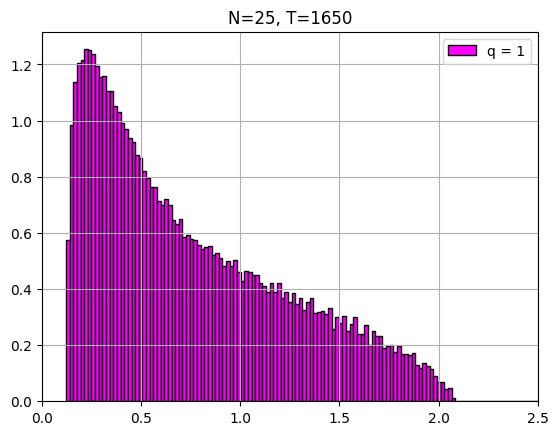

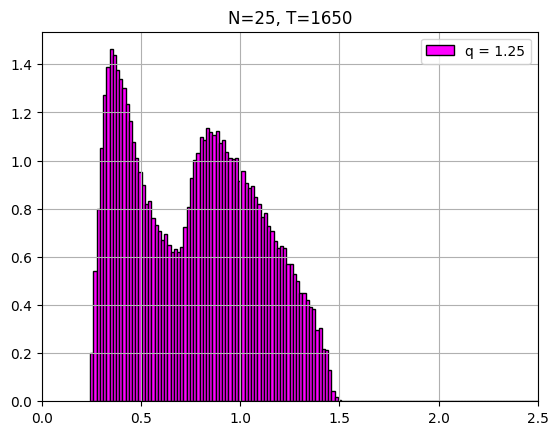

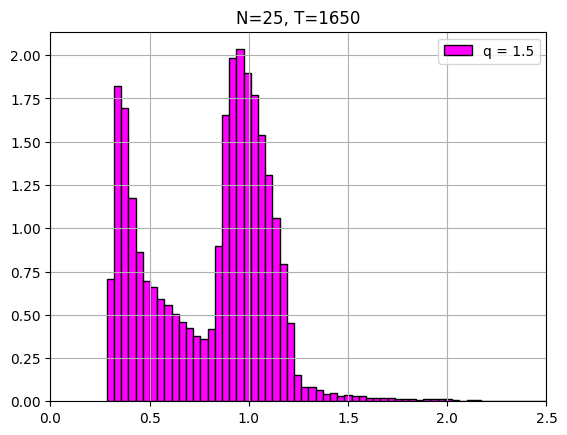

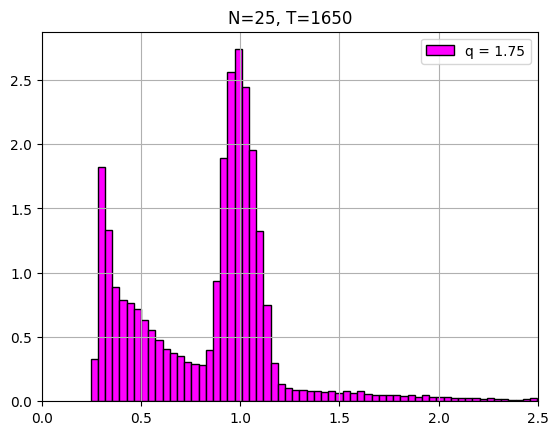

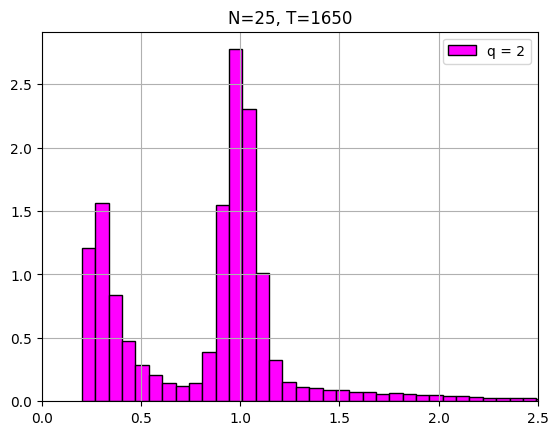

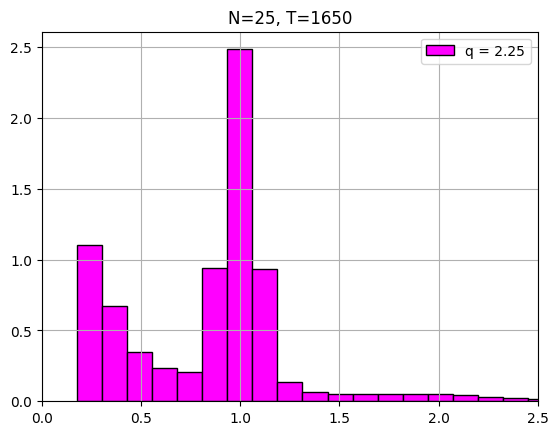

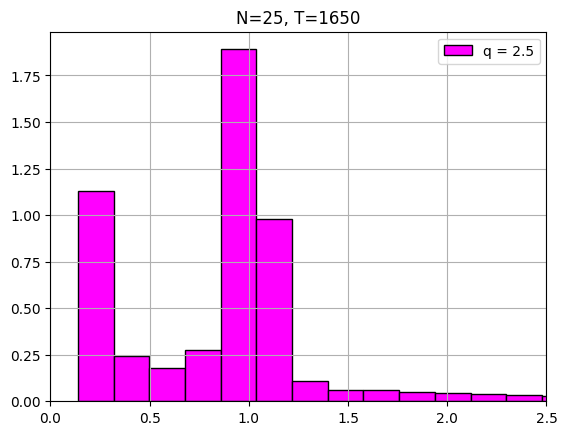

In [71]:
for i in range(len(Power_eigvals)):
    plt.title("N=25, T=1650")
    n, bins, patches = plt.hist(Power_eigvals[i], bins = 21000, density = True, edgecolor ="black", label = f"q = {Q[i]}", color = "magenta")
    plt.legend()
    plt.xlim(0, 2.5)
    plt.grid()
    plt.show()

Según estos resultados el valor óptimo es $q = 1.5$, dicho tiene un efecto similar a prolongar la serie de tiempo

De nuestra expresión para $C(k, l)_T$, vemos que podemos escribir:

$$

C(k, l)_T \approx C(k, l)_{\infty} + \frac{C_1(k, l)}{\sqrt{T}}

$$

De donde para los elementos fuera de la diagonal y de los bloques, tenemos que $C_{\infty} = 0$, luego al aplicar mapeo de potencias para los elementos dentro de los bloques diagonales:
$$ 

C(k,l)_T^q \sim f(p_b, q) + \frac{1}{\sqrt{T}} + o(|\frac{1}{\sqrt{T}}|)

$$

Para los que están fuera de los bloques: 

$$ 

C(k,l)_T^q \sim \frac{1}{T^{q/2}} + o(|\frac{1}{T^{q/2}}|)

$$
Por lo tanto el mapeo de potencias funciona porque los elementos fuera de los bloques diagonales en la matriz de correlaciones se van a 0 más rápido que aquellos que están dentro.

Para validar el modelo, el árticulo propone 3 estructuras de empresas y pesos

In [36]:
# Estructura 1
k_b1 = [76, 2, 4, 7, 10, 15, 20, 30, 42, 64, 98, 140]
p_b1 =[0, 0.5, 0.75, 0.85, 0.9, 0.93, 0.95, 0.96, 0.97, 0.984, 0.989, 0.99]
b1 = [0,1,2,3,4,5,6,7,8,9,10,11]

#Estructura 2
k_b2= [256, 4, 8, 16, 32, 64, 128]
p_b2= [0, 0.008, 0.01, 0.03, 0.07, 0.2, 0.99]
b2 = [0,1,2,3,4,5,6]

#Estructura 3

k_b3 = [400, 4, 104]
p_b3 = [0, 0.75, 0.99]
b3 = [0,1,2]





In [ ]:
data = {
    "Top Structure": {
        "b": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
        "k_b": [2, 4, 7, 10, 15, 20, 30, 42, 64, 98, 140],
        "p_b": [0.5, 0.75, 0.85, 0.9, 0.93, 0.95, 0.96, 0.97, 0.984, 0.989, 0.99],
    },
    "Middle Structure": {
        "b": [1, 2, 3, 4, 5, 6],
        "k_b": [4, 8, 16, 32, 64, 128],
        "p_b": [0.008, 0.01, 0.03, 0.07, 0.2, 0.99],
    },
    "Bottom Structure": {
        "b": [1, 2],
        "k_b": [4, 104],
        "p_b": [0.75, 0.99],
    },
}

# Crear DataFrames
top_structure_df = pd.DataFrame(data["Top Structure"])
middle_structure_df = pd.DataFrame(data["Middle Structure"])
bottom_structure_df = pd.DataFrame(data["Bottom Structure"])


In [45]:
top_structure_df.head()

,b,k_b,p_b
0,1,2,0.50
1,2,4,0.75
2,3,7,0.85
3,4,10,0.90
4,5,15,0.93


In [46]:
middle_structure_df.head()

,b,k_b,p_b
0,1,4,0.008
1,2,8,0.010
2,3,16,0.030
3,4,32,0.070
4,5,64,0.200


In [47]:
bottom_structure_df.head()

,b,k_b,p_b
0,1,4,0.75
1,2,104,0.99


In [56]:
Mval1 = M(b1, k_b1, p_b1, 1650)
Mval2 = M(b2, k_b2, p_b2, 1650)
Mval3 = M(b3, k_b3, p_b3, 1650)

In [57]:
Ms = [Mval1, Mval2, Mval3]

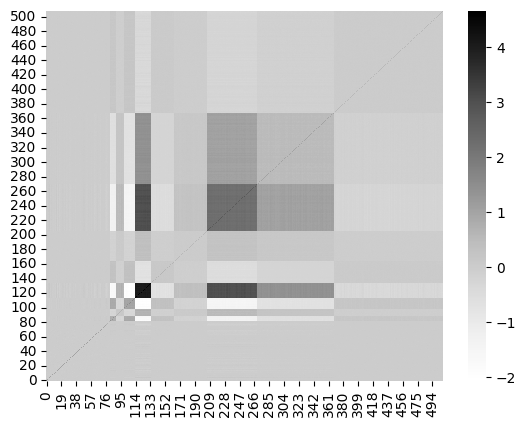

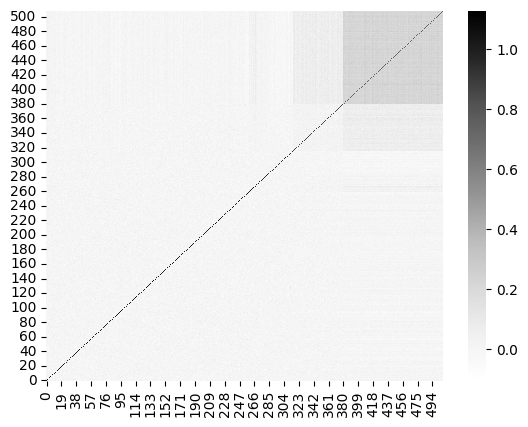

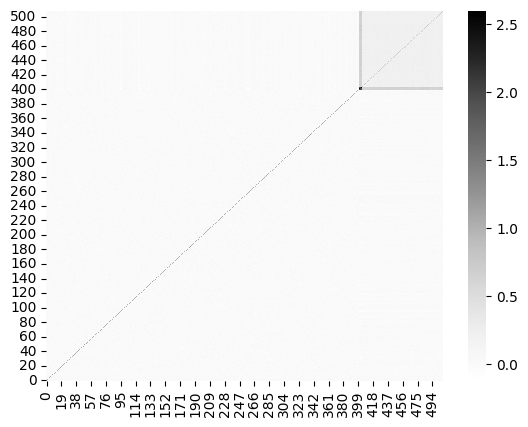

In [58]:
for i in range(3):
    sb.heatmap(Ms[i], cmap = "Greys")
    plt.gca().invert_yaxis()
    plt.show()

In [61]:
evalsvals = []
for i in range(3):
    evalsvals.append(np.linalg.eigvals(Ms[i]))

In [72]:
pmv = []
for i in range(3):
    pmv.append(np.linalg.eigvals(np.sign(Ms[i])*(np.power(np.abs(Ms[i]), 1.5))))

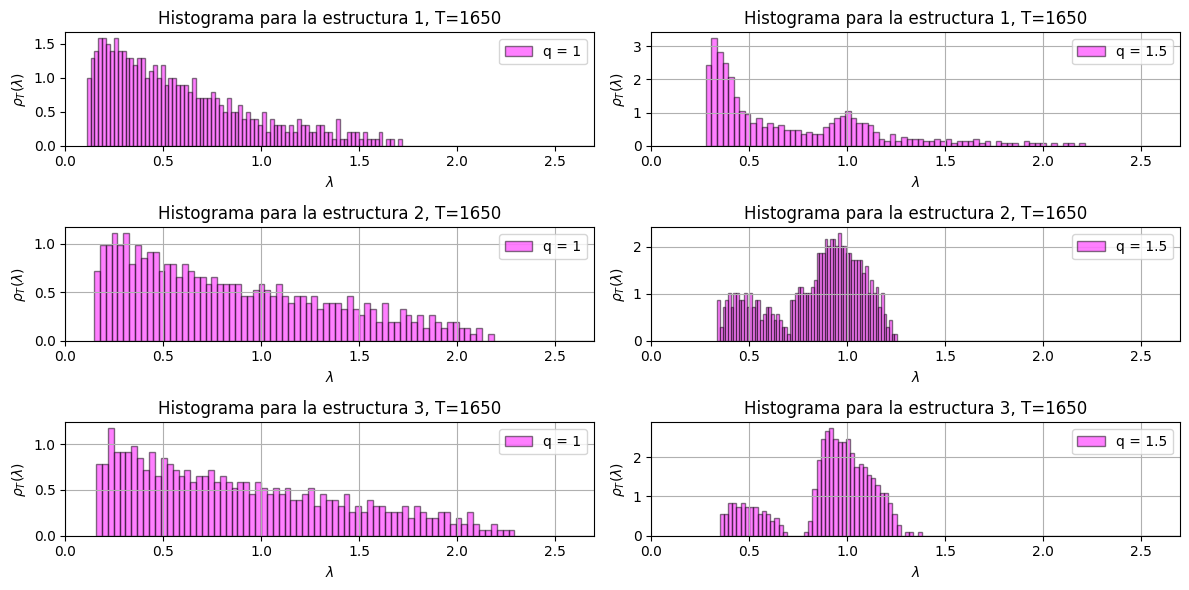

In [76]:
plt.figure(figsize=(12, 6))
plt.subplot(3, 2, 1)
plt.title("Histograma para la estructura 1, T=1650")
n,bins, patches = plt.hist(evalsvals[0], bins = 30*K, density = True, color = "magenta", alpha = 0.5, edgecolor="black", label ="q = 1")
plt.xlim(0, 2.7)
plt.xlabel("$\\lambda$")
plt.ylabel("$\\rho_T(\\lambda$)")
plt.legend()

plt.subplot(3, 2, 2)
plt.title("Histograma para la estructura 1, T=1650")
n,bins, patches = plt.hist(pmv[0], bins = 30*K, density = True, color = "magenta", alpha = 0.5, edgecolor="black", label ="q = 1.5")
plt.grid()
plt.xlim(0, 2.7)
plt.xlabel("$\\lambda$")
plt.ylabel("$\\rho_T(\\lambda$)")
plt.legend()




plt.subplot(3, 2, 3)
plt.title("Histograma para la estructura 2, T=1650")
n,bins, patches = plt.hist(evalsvals[1], bins = 2*K,density = True, color = "magenta", alpha = 0.5, edgecolor="black", label = "q = 1")
plt.grid()
plt.xlim(0, 2.7)
plt.xlabel("$\\lambda$")
plt.ylabel("$\\rho_T(\\lambda$)")
plt.legend()
plt.subplot(3, 2, 4)

plt.title("Histograma para la estructura 2, T=1650")
n,bins, patches = plt.hist(pmv[1], bins = 2*K, density = True, color = "magenta", alpha = 0.5, edgecolor="black", label =f"q = 1.5")
plt.grid()
plt.xlim(0, 2.7)
plt.xlabel("$\\lambda$")
plt.ylabel("$\\rho_T(\\lambda$)")
plt.legend()




plt.subplot(3, 2, 5)
plt.title("Histograma para la estructura 3, T=1650")
n,bins, patches = plt.hist(evalsvals[2], bins = 2*K,density = True, color = "magenta", alpha = 0.5, edgecolor="black", label = "q = 1")
plt.grid()
plt.xlim(0, 2.7)
plt.xlabel("$\\lambda$")
plt.ylabel("$\\rho_T(\\lambda$)")
plt.legend()

plt.subplot(3, 2, 6)
plt.title("Histograma para la estructura 3, T=1650")
n,bins, patches = plt.hist(pmv[2], bins = 2*K,density = True, color = "magenta", alpha = 0.5, edgecolor="black", label ="q = 1.5")
plt.grid()
plt.xlim(0, 2.7)
plt.xlabel("$\\lambda$")
plt.ylabel("$\\rho_T(\\lambda$)")
plt.legend()
plt.tight_layout() 
plt.show()